In [1]:

import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (180,180,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

In [4]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [5]:
bs=5     #Setting batch size
train_dir = r"C:\Users\devad\Desktop\smart agriculture\half\Soil types"
validation_dir = r"C:\Users\devad\Desktop\smart agriculture\half\Soil types"

In [6]:
labels = ['Black Soil', 'Cinder Soil','Laterite Soil','Peat Soil','Yellow Soil']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    
        train = get_data(r'C:\Users\devad\Desktop\smart agriculture\half\Soil types')
        val = get_data(r'C:\Users\devad\Desktop\smart agriculture\half\Soil types')
        return np.array(data)

In [7]:
'''plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])


plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])'''

'plt.figure(figsize = (5,5))\nplt.imshow(train[1][0])\nplt.title(labels[train[0][1]])\n\n\nplt.figure(figsize = (5,5))\nplt.imshow(train[-1][0])\nplt.title(labels[train[-1][1]])'

In [8]:
#Setting testing directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
# Flow training images in batches of 20 using train_datagen generator
#Flow_from_directory function lets the classifier directly identify the labels from the name of the directories the image lies in
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=bs,class_mode='categorical',target_size=(180,180))
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=bs,
                                                         class_mode  = 'categorical',
                                                         target_size=(180,180))

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list


Found 156 images belonging to 5 classes.
Found 156 images belonging to 5 classes.


In [9]:
def plot_images(img, labels):
	plt.figure(figsize=[5, 1])
	for i in range(5):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')


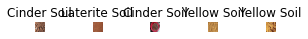

In [10]:
plot_images(x,y)

In [11]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=150 // bs,
                    epochs=50,
                    validation_steps=150 // bs,
                    verbose=2)


Epoch 1/50
30/30 - 6s - loss: 1.6294 - acc: 0.2123 - val_loss: 1.5581 - val_acc: 0.3600 - 6s/epoch - 195ms/step
Epoch 2/50
30/30 - 3s - loss: 1.4295 - acc: 0.3562 - val_loss: 1.1441 - val_acc: 0.4000 - 3s/epoch - 115ms/step
Epoch 3/50
30/30 - 3s - loss: 1.2554 - acc: 0.4041 - val_loss: 1.0836 - val_acc: 0.4267 - 3s/epoch - 115ms/step
Epoch 4/50
30/30 - 3s - loss: 1.1679 - acc: 0.4521 - val_loss: 1.0555 - val_acc: 0.5467 - 3s/epoch - 115ms/step
Epoch 5/50
30/30 - 3s - loss: 1.0637 - acc: 0.4247 - val_loss: 0.9196 - val_acc: 0.4800 - 3s/epoch - 115ms/step
Epoch 6/50
30/30 - 3s - loss: 1.0308 - acc: 0.4247 - val_loss: 0.9910 - val_acc: 0.4400 - 3s/epoch - 115ms/step
Epoch 7/50
30/30 - 4s - loss: 1.0321 - acc: 0.4452 - val_loss: 1.0127 - val_acc: 0.5533 - 4s/epoch - 117ms/step
Epoch 8/50
30/30 - 4s - loss: 0.9464 - acc: 0.5342 - val_loss: 0.9967 - val_acc: 0.6600 - 4s/epoch - 117ms/step
Epoch 9/50
30/30 - 4s - loss: 1.0489 - acc: 0.4452 - val_loss: 0.8750 - val_acc: 0.6267 - 4s/epoch - 120

In [12]:
model.save('model.h5')

In [13]:
from IPython.display import FileLink
FileLink('model.h5')

C:\Users\devad\100% implementation\notebooks\model.h5